In [220]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [537]:
# Define the lens corresponding parameters (order preserved)
# POW
pow_params = ['Len Model', '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', '$\gamma$ (PWI)']

# SIE
sie_params = ['Lens Model','$\sigma$', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# NFW 
nfw_params = ['Lens Model', 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']

# EIN
ein_params = ['Lens Model', 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', r'$\alpha_{e}$']

# SHEAR 
shear_params = ['Lens Model', '$z_{s,fid}$', 'x', 'y', '$\gamma$', '$θ_{\gamma}$', 'NaN', '$\kappa$']

# Sersic
sersic_params = ['Lens Model', '$M_{tot}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{e}$', '$n$']

# Cored SIE
cored_sie_params = ['Lens Model', 'M', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

model_list = ['POW', 'SIE', 'ANFW', 'EIN', 'PERT', 'SERS']


In [538]:
# Model Opening
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'
lens_name = f'"{model_path}"'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result


# with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
#     py = file.readlines()

# py

['------------------------------------------\n',
 'optimize ndim=0\n',
 'run 1: 0 lens models calculated\n',
 'chi^2 = 1.000000e+30  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 1.000000e+30\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  3.000000e+00  1.000000e+02  0.000000e+00  5.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [539]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 1


['run 1: 0 lens models calculated\n',
 'chi^2 = 1.000000e+30  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 1.000000e+30\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  3.000000e+00  1.000000e+02  0.000000e+00  5.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [540]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.300000e+02', '2.080000e+01', '2.075000e+01', '1.070000e-01', '2.338000e+01', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.090000e+01', '2.064000e+01', '3.000000e+00', '1.000000e+02', '0.000000e+00', '5.000000e+00']
Number of lens profiles: 2


{'sie': [130.0, 20.8, 20.75, 0.107, 23.38, 0.0, 0.0],
 'pert': [1.0, 20.9, 20.64, 3.0, 100.0, 0.0, 5.0]}

In [541]:
# Initialize a dictionary to hold the lens parameters
set_point_dict = {}

# Extract the lens parameters
set_points = []
for line in opt_result:
    if line.startswith('point'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)

set_point_values = [float(x) for x in parts[1:]]

set_point_values

['point', '1.0000', '2.078000e+01', '2.078000e+01']


[1.0, 20.78, 20.78]

In [542]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)


In [543]:
df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,sie,130.0,20.8,20.75,0.107,23.38,0.0,0.0
1,pert,1.0,20.9,20.64,3.000,100.00,0.0,5.0


In [544]:
df['Lens Name'] = df['Lens Name'].apply(lambda x: f'"{x}"')

In [545]:
# Use a single, clear dictionary for mapping. It's easier to manage.
model_params = {
    'POW': pow_params,
    'SIE': sie_params,
    'NFW': nfw_params, # Assuming ANFW maps to NFW params
    'EIN': ein_params,
    'PERT': shear_params, # Assuming PERT maps to SHEAR params
    'SERSIC': sersic_params # Assuming SERS maps to SERSIC
}
# --- The Corrected Logic ---

# A list to hold our new rows. Each row will be a dictionary.
processed_rows = []

# Get the column names from the original DataFrame to use for our new header rows.
df_columns = df.columns.tolist()

# Iterate through each row of the original DataFrame
for index, row in df.iterrows():
    lens_name_val = row['Lens Name']

    # Check if the 'Lens Name' is a string (like '"pow"') before trying string operations
    if isinstance(lens_name_val, str):
        # Clean the name to get a key like 'POW', 'SIE', etc.
        # This removes quotes and converts to uppercase to match the dictionary keys.
        model_key = lens_name_val.strip('"').upper()

        # Check if this key exists in our parameter dictionary
        if model_key in model_params:
            # It's a model! First, create and add the header row.
            param_names_list = model_params[model_key]
            
            # Use zip to create a dictionary mapping column names to parameter names
            header_row = dict(zip(df_columns, param_names_list))
            processed_rows.append(header_row)

    # ALWAYS add the original row (whether it was a model row or a data row)
    processed_rows.append(row.to_dict())

# Create the final, new DataFrame from our list of processed rows
final_df = pd.DataFrame(processed_rows)

print("Final DataFrame with Parameter Headers:")
print(final_df)

Final DataFrame with Parameter Headers:
    Lens Name       param1 param2 param3    param4        param5      param6  \
0  Lens Model     $\sigma$      x      y         e       $θ_{e}$  $r_{core}$   
1       "sie"        130.0   20.8  20.75     0.107         23.38         0.0   
2  Lens Model  $z_{s,fid}$      x      y  $\gamma$  $θ_{\gamma}$         NaN   
3      "pert"          1.0   20.9  20.64       3.0         100.0         0.0   

     param7  
0       NaN  
1       0.0  
2  $\kappa$  
3       5.0  


In [546]:
final_df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,Lens Model,$\sigma$,x,y,e,$θ_{e}$,$r_{core}$,NaN
1,"""sie""",130.0,20.8,20.75,0.107,23.38,0.0,0.0
2,Lens Model,"$z_{s,fid}$",x,y,$\gamma$,$θ_{\gamma}$,NaN,$\kappa$
3,"""pert""",1.0,20.9,20.64,3.0,100.0,0.0,5.0


In [547]:
with open(model_path + '/' + 'pos_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'Test/SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 1', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.80, 20.75, 0.107, 23.38, 0.000000e+00, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.64, 3.0, 100.0, 0.0, 5.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_point(1, 0, 0, 0)\n',
 '\n',
 '# model_init needs to be don

In [548]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 0
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/sie"
Found glafic.set_lens
Found glafic.set_point


In [549]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/sie_lens.fits 



In [550]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: Test/SIE+SHEAR/sie_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [551]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa


array([[0.14583714, 0.14687921, 0.14793123, ..., 0.1653072 , 0.16410884,
        0.16291921],
       [0.14669019, 0.14774983, 0.14881982, ..., 0.16634162, 0.16511944,
        0.16390653],
       [0.14754759, 0.14862508, 0.14971334, ..., 0.16737993, 0.16613352,
        0.16489695],
       ...,
       [0.15467492, 0.15574661, 0.15682575, ..., 0.1484443 , 0.14742781,
        0.14641961],
       [0.15378754, 0.15483965, 0.1558988 , ..., 0.14751221, 0.1465137 ,
        0.14552309],
       [0.15290323, 0.1539361 , 0.15497556, ..., 0.1465869 , 0.145606  ,
        0.14463267]], dtype='>f4')

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_11122/1470999101.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


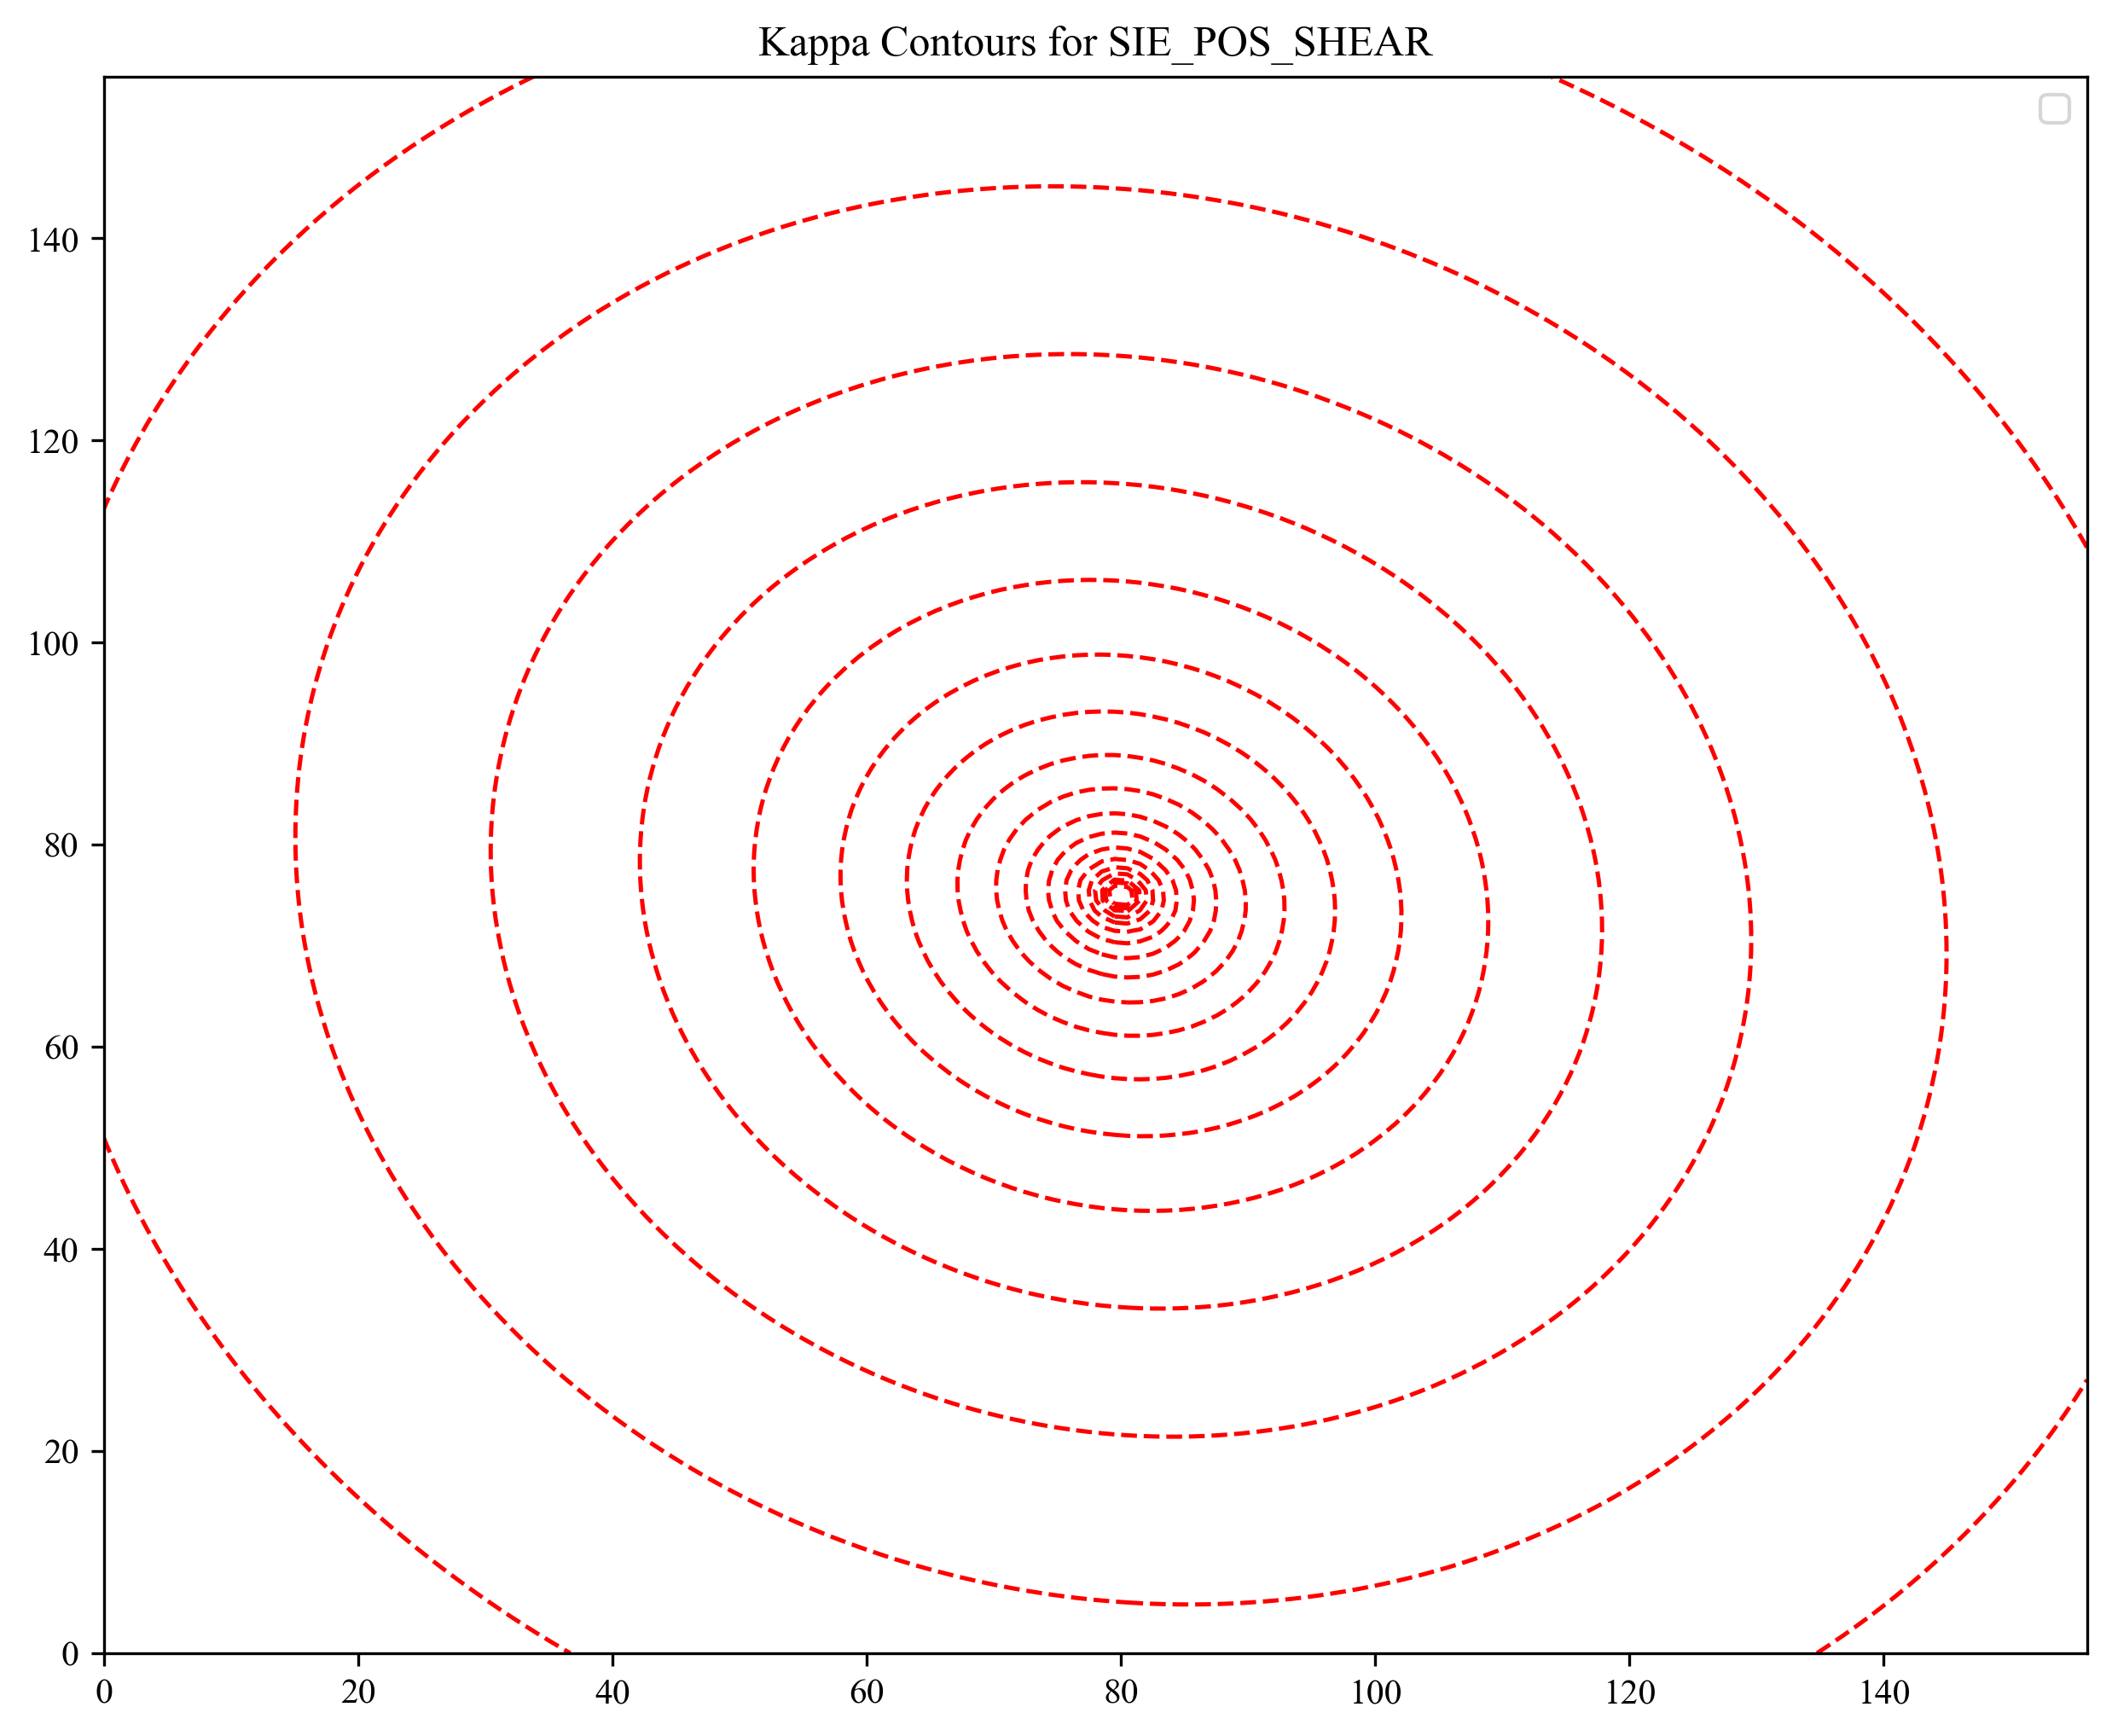

In [552]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(10, 8))
# plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
# cbar = plt.colorbar(label=r'$\kappa$')
# cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa, 
    levels=levels, 
    colors='red', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
# plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
# plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
# plt.scatter(crit_curves['1'], crit_curves['2'], c='yellow', s=5, label='Critical Curves', marker='o')
# plt.scatter(crit_curves['3'], crit_curves['4'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['5'], crit_curves['6'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['7'], crit_curves['8'], c='yellow', s=5, marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.xlim(0, kappa.shape[1])
plt.ylim(0, kappa.shape[0])
# plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


In [553]:
lens_name = model_path
lens_name = lens_name + '/' + model_ver + '_macro'
lens_name = f'"{lens_name}"'
print(lens_name)

# Read original file
with open('Test/kappa_common.py', 'r') as f:
    py = f.readlines()

# Modify lines
new_lines = []
for line in py:
    if 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_lens(1' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][0]}, 0.261343256161012, {df['param1'][0]}, {df['param2'][0]}, {df['param3'][0]}, {df['param4'][0]}, {df['param5'][0]}, {df['param6'][0]}, {df['param7'][0]})\n"
    elif 'glafic.set_lens(2' in line:
        line = f"glafic.set_lens(2, {df['Lens Name'][1]}, 0.261343256161012, {df['param1'][1]}, {df['param2'][1]}, {df['param3'][1]}, {df['param4'][1]}, {df['param5'][1]}, {df['param6'][1]}, {df['param7'][1]})\n"
    elif 'glafic.set_lens(3' in line:
        line = f"glafic.set_lens(3, {df['Lens Name'][2]}, 0.261343256161012, {df['param1'][2]}, {df['param2'][2]}, {df['param3'][2]}, {df['param4'][2]}, {df['param5'][2]}, {df['param6'][2]}, {df['param7'][2]})\n"
    elif 'glafic.set_lens(4' in line:
        line = f"glafic.set_lens(4, {df['Lens Name'][3]}, 0.261343256161012, {df['param1'][3]}, {df['param2'][3]}, {df['param3'][3]}, {df['param4'][3]}, {df['param5'][3]}, {df['param6'][3]}, {df['param7'][3]})\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write once, after all edits
with open('Test/kappa_common.py', 'w') as f:
    f.writelines(new_lines)

"Test/SIE+SHEAR/SIE_POS_SHEAR_macro"
Found glafic.set_lens
Found glafic.set_point


In [554]:
%run Test/kappa_common.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits 



In [555]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'
print(image)

hdu_list = fits.open(image)
hdu_list.info()

Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [556]:
# Extract kappa 
kappa_macro = hdu_list[0].data[3]
kappa_macro = np.array(kappa_macro)
kappa_macro

gamma1 = hdu_list[0].data[4]
gamma1 = np.array(gamma1)
gamma2 = hdu_list[0].data[5]
gamma2 = np.array(gamma2)

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_11122/3824648672.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


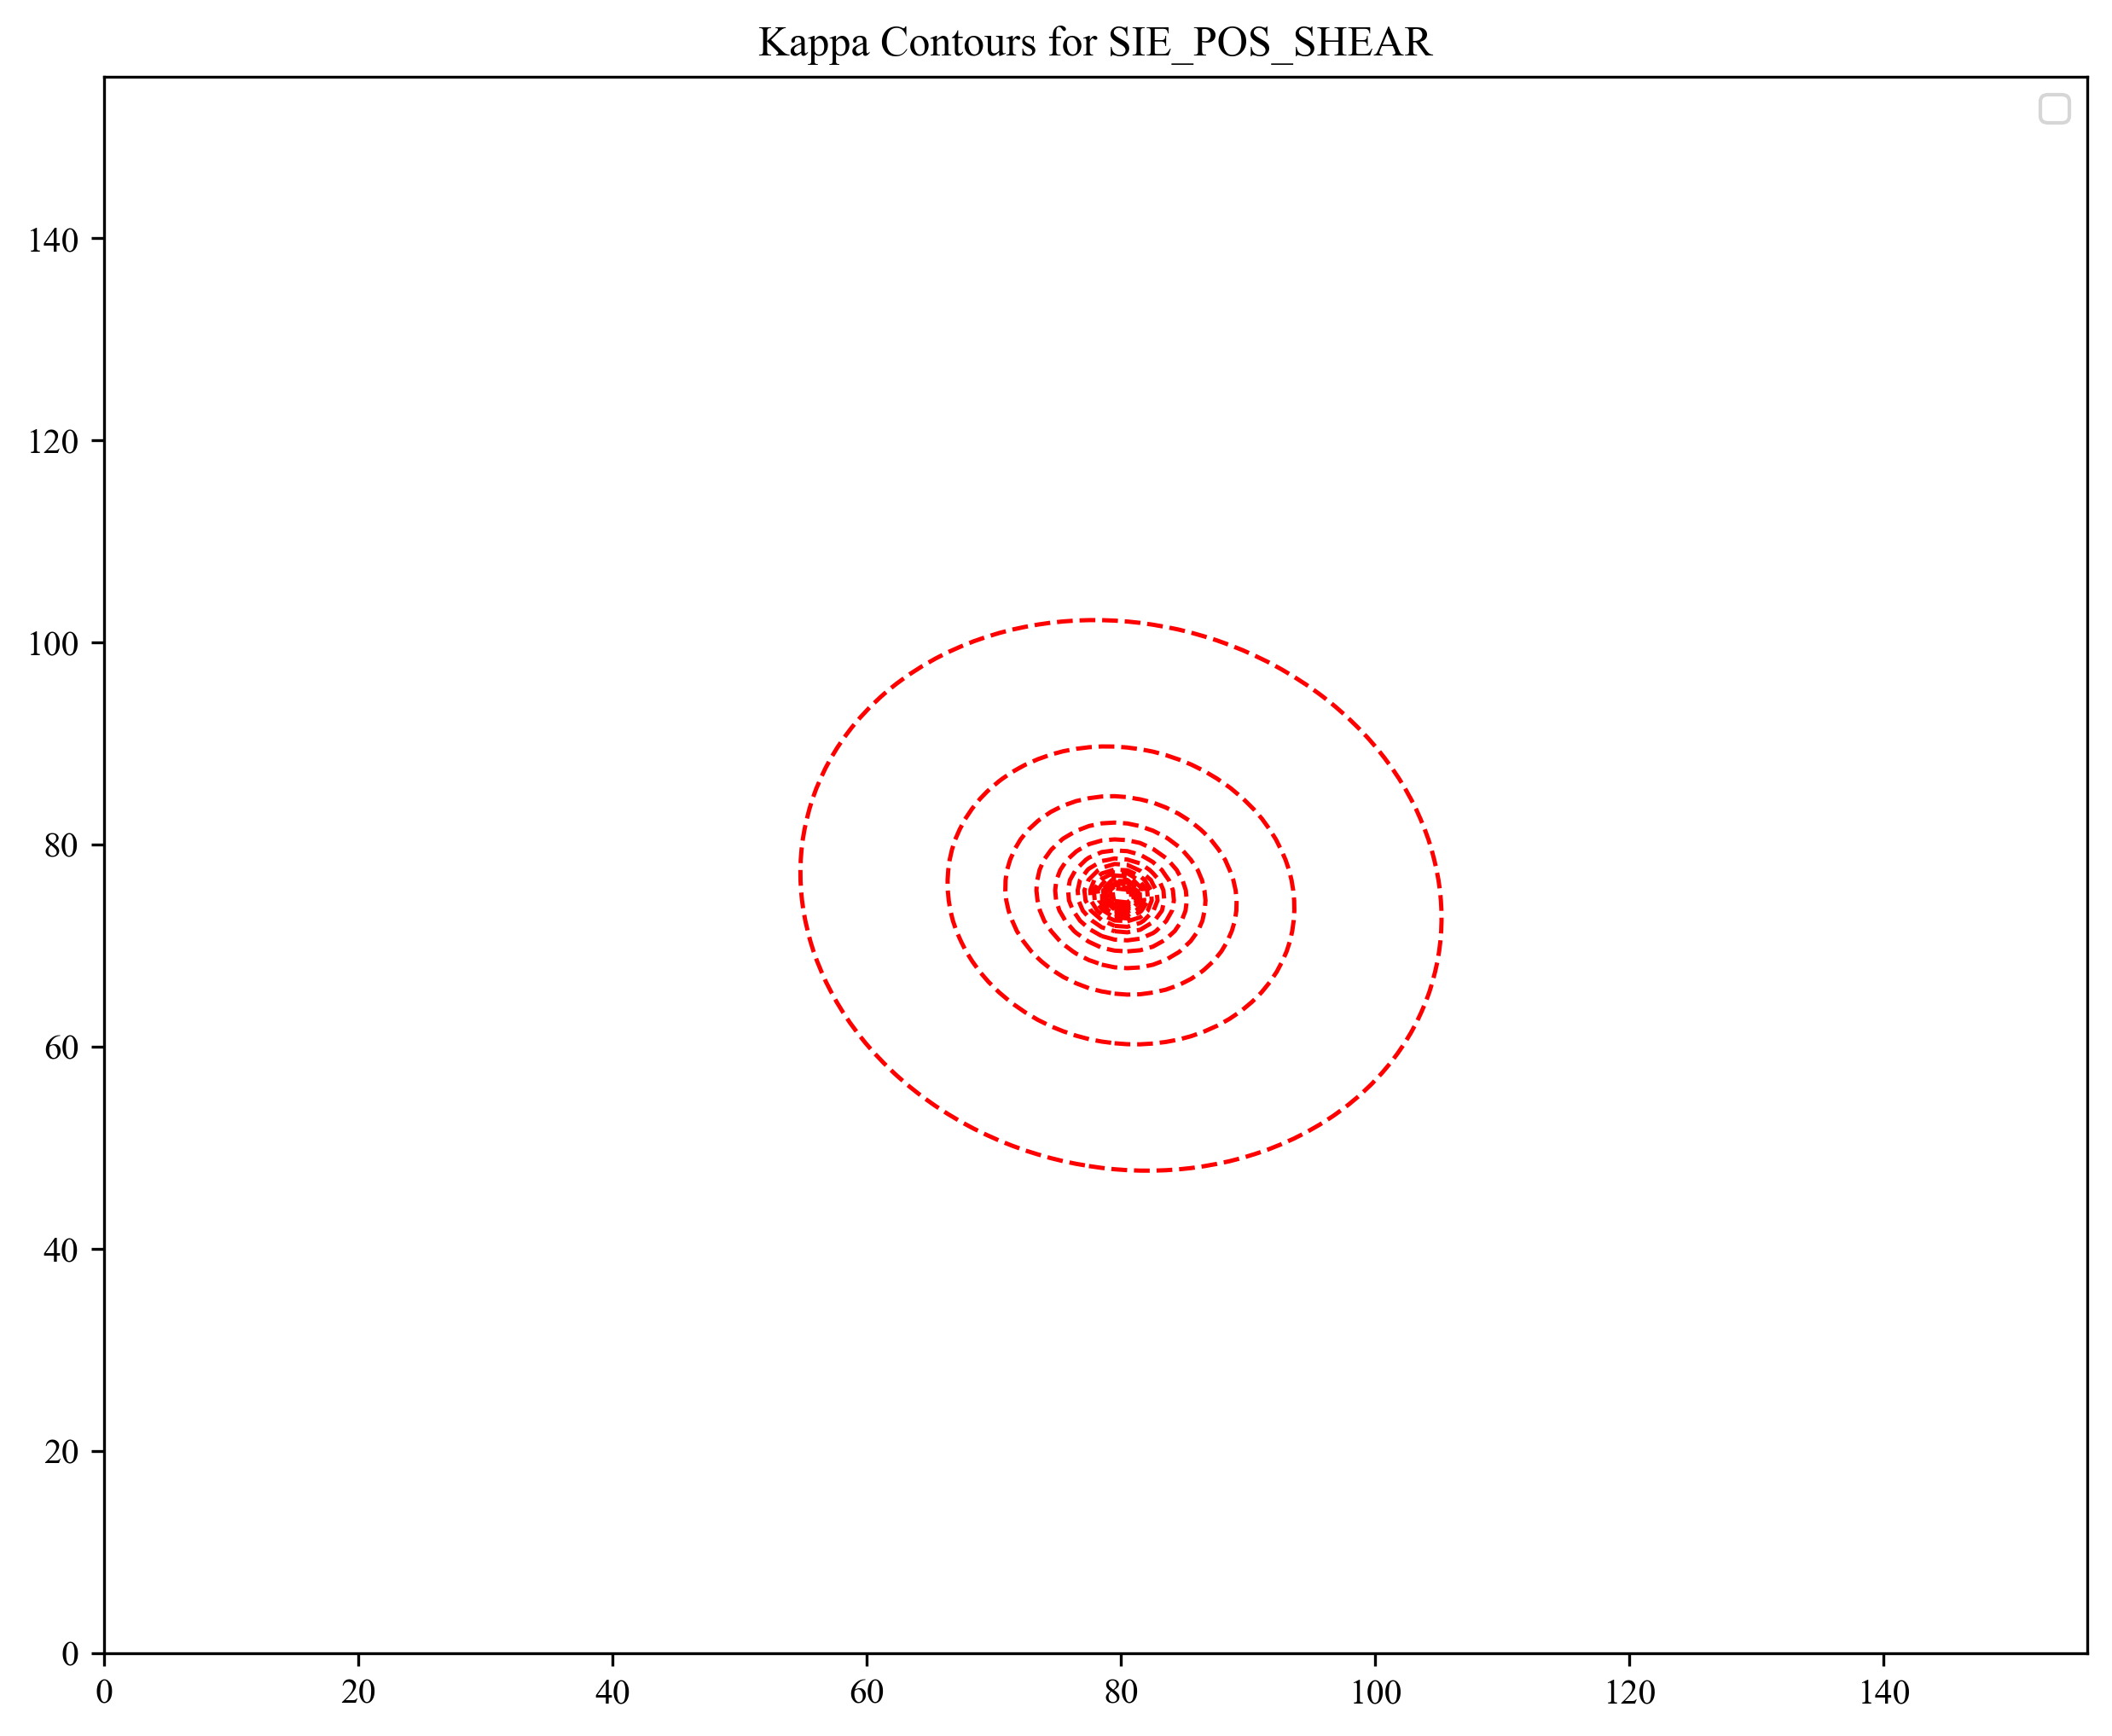

In [557]:
norm = ImageNormalize(kappa_macro, stretch=LogStretch())
plt.figure(figsize=(10, 8))
# plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
# cbar = plt.colorbar(label=r'$\kappa$')
# cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa_macro.min() + 1e-6), np.log10(kappa_macro.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa_macro, 
    levels=levels, 
    colors='red', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa_macro.shape[1], 0, kappa_macro.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
# plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
# plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
# plt.scatter(crit_curves['1'], crit_curves['2'], c='yellow', s=5, label='Critical Curves', marker='o')
# plt.scatter(crit_curves['3'], crit_curves['4'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['5'], crit_curves['6'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['7'], crit_curves['8'], c='yellow', s=5, marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.xlim(0, kappa_macro.shape[1])
plt.ylim(0, kappa_macro.shape[0])
# plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


In [558]:
gamma1

array([[-2.828538 , -2.8267527, -2.824915 , ..., -2.816844 , -2.819078 ,
        -2.82125  ],
       [-2.8305652, -2.8287878, -2.8269567, ..., -2.819078 , -2.821309 ,
        -2.8234773],
       [-2.832639 , -2.8308704, -2.8290477, ..., -2.8213706, -2.8235977,
        -2.8257601],
       ...,
       [-2.8210356, -2.819078 , -2.8170674, ..., -2.8093224, -2.8113744,
        -2.8133755],
       [-2.819078 , -2.817118 , -2.8151066, ..., -2.807526 , -2.809574 ,
        -2.811572 ],
       [-2.8171666, -2.8152058, -2.8131948, ..., -2.8057792, -2.807822 ,
        -2.8098161]], dtype='>f4')

In [559]:
gamma = gamma1 / np.cos(2 * np.deg2rad(df['param5'][1]))
gamma

array([[3.0100672, 3.0081673, 3.0062118, ..., 2.9976227, 3.0000002,
        3.0023115],
       [3.0122247, 3.010333 , 3.0083845, ..., 3.0000002, 3.0023744,
        3.0046818],
       [3.0144315, 3.0125494, 3.0106096, ..., 3.00244  , 3.0048099,
        3.007111 ],
       ...,
       [3.0020833, 3.0000002, 2.9978604, ..., 2.9896185, 2.9918022,
        2.9939318],
       [3.0000002, 2.9979143, 2.995774 , ..., 2.987707 , 2.989886 ,
        2.9920125],
       [2.997966 , 2.9958794, 2.9937394, ..., 2.985848 , 2.9880219,
        2.9901438]], dtype=float32)

In [560]:
gamma = gamma2 / np.sin(2 * np.deg2rad(df['param5'][1]))
gamma

array([[3.425501 , 3.4288595, 3.432185 , ..., 2.5167181, 2.5201778,
        2.5236983],
       [3.427576 , 3.4310577, 3.4345098, ..., 2.5136495, 2.517267 ,
        2.520942 ],
       [3.4295743, 3.4331803, 3.4367607, ..., 2.5106597, 2.5144377,
        2.5182695],
       ...,
       [2.547797 , 2.5446272, 2.5415099, ..., 3.4330838, 3.430461 ,
        3.4277775],
       [2.5503552, 2.5473154, 2.5443301, ..., 3.4299724, 3.427475 ,
        3.4249146],
       [2.5529757, 2.5500631, 2.5472083, ..., 3.4268239, 3.4244492,
        3.4220095]], dtype=float32)

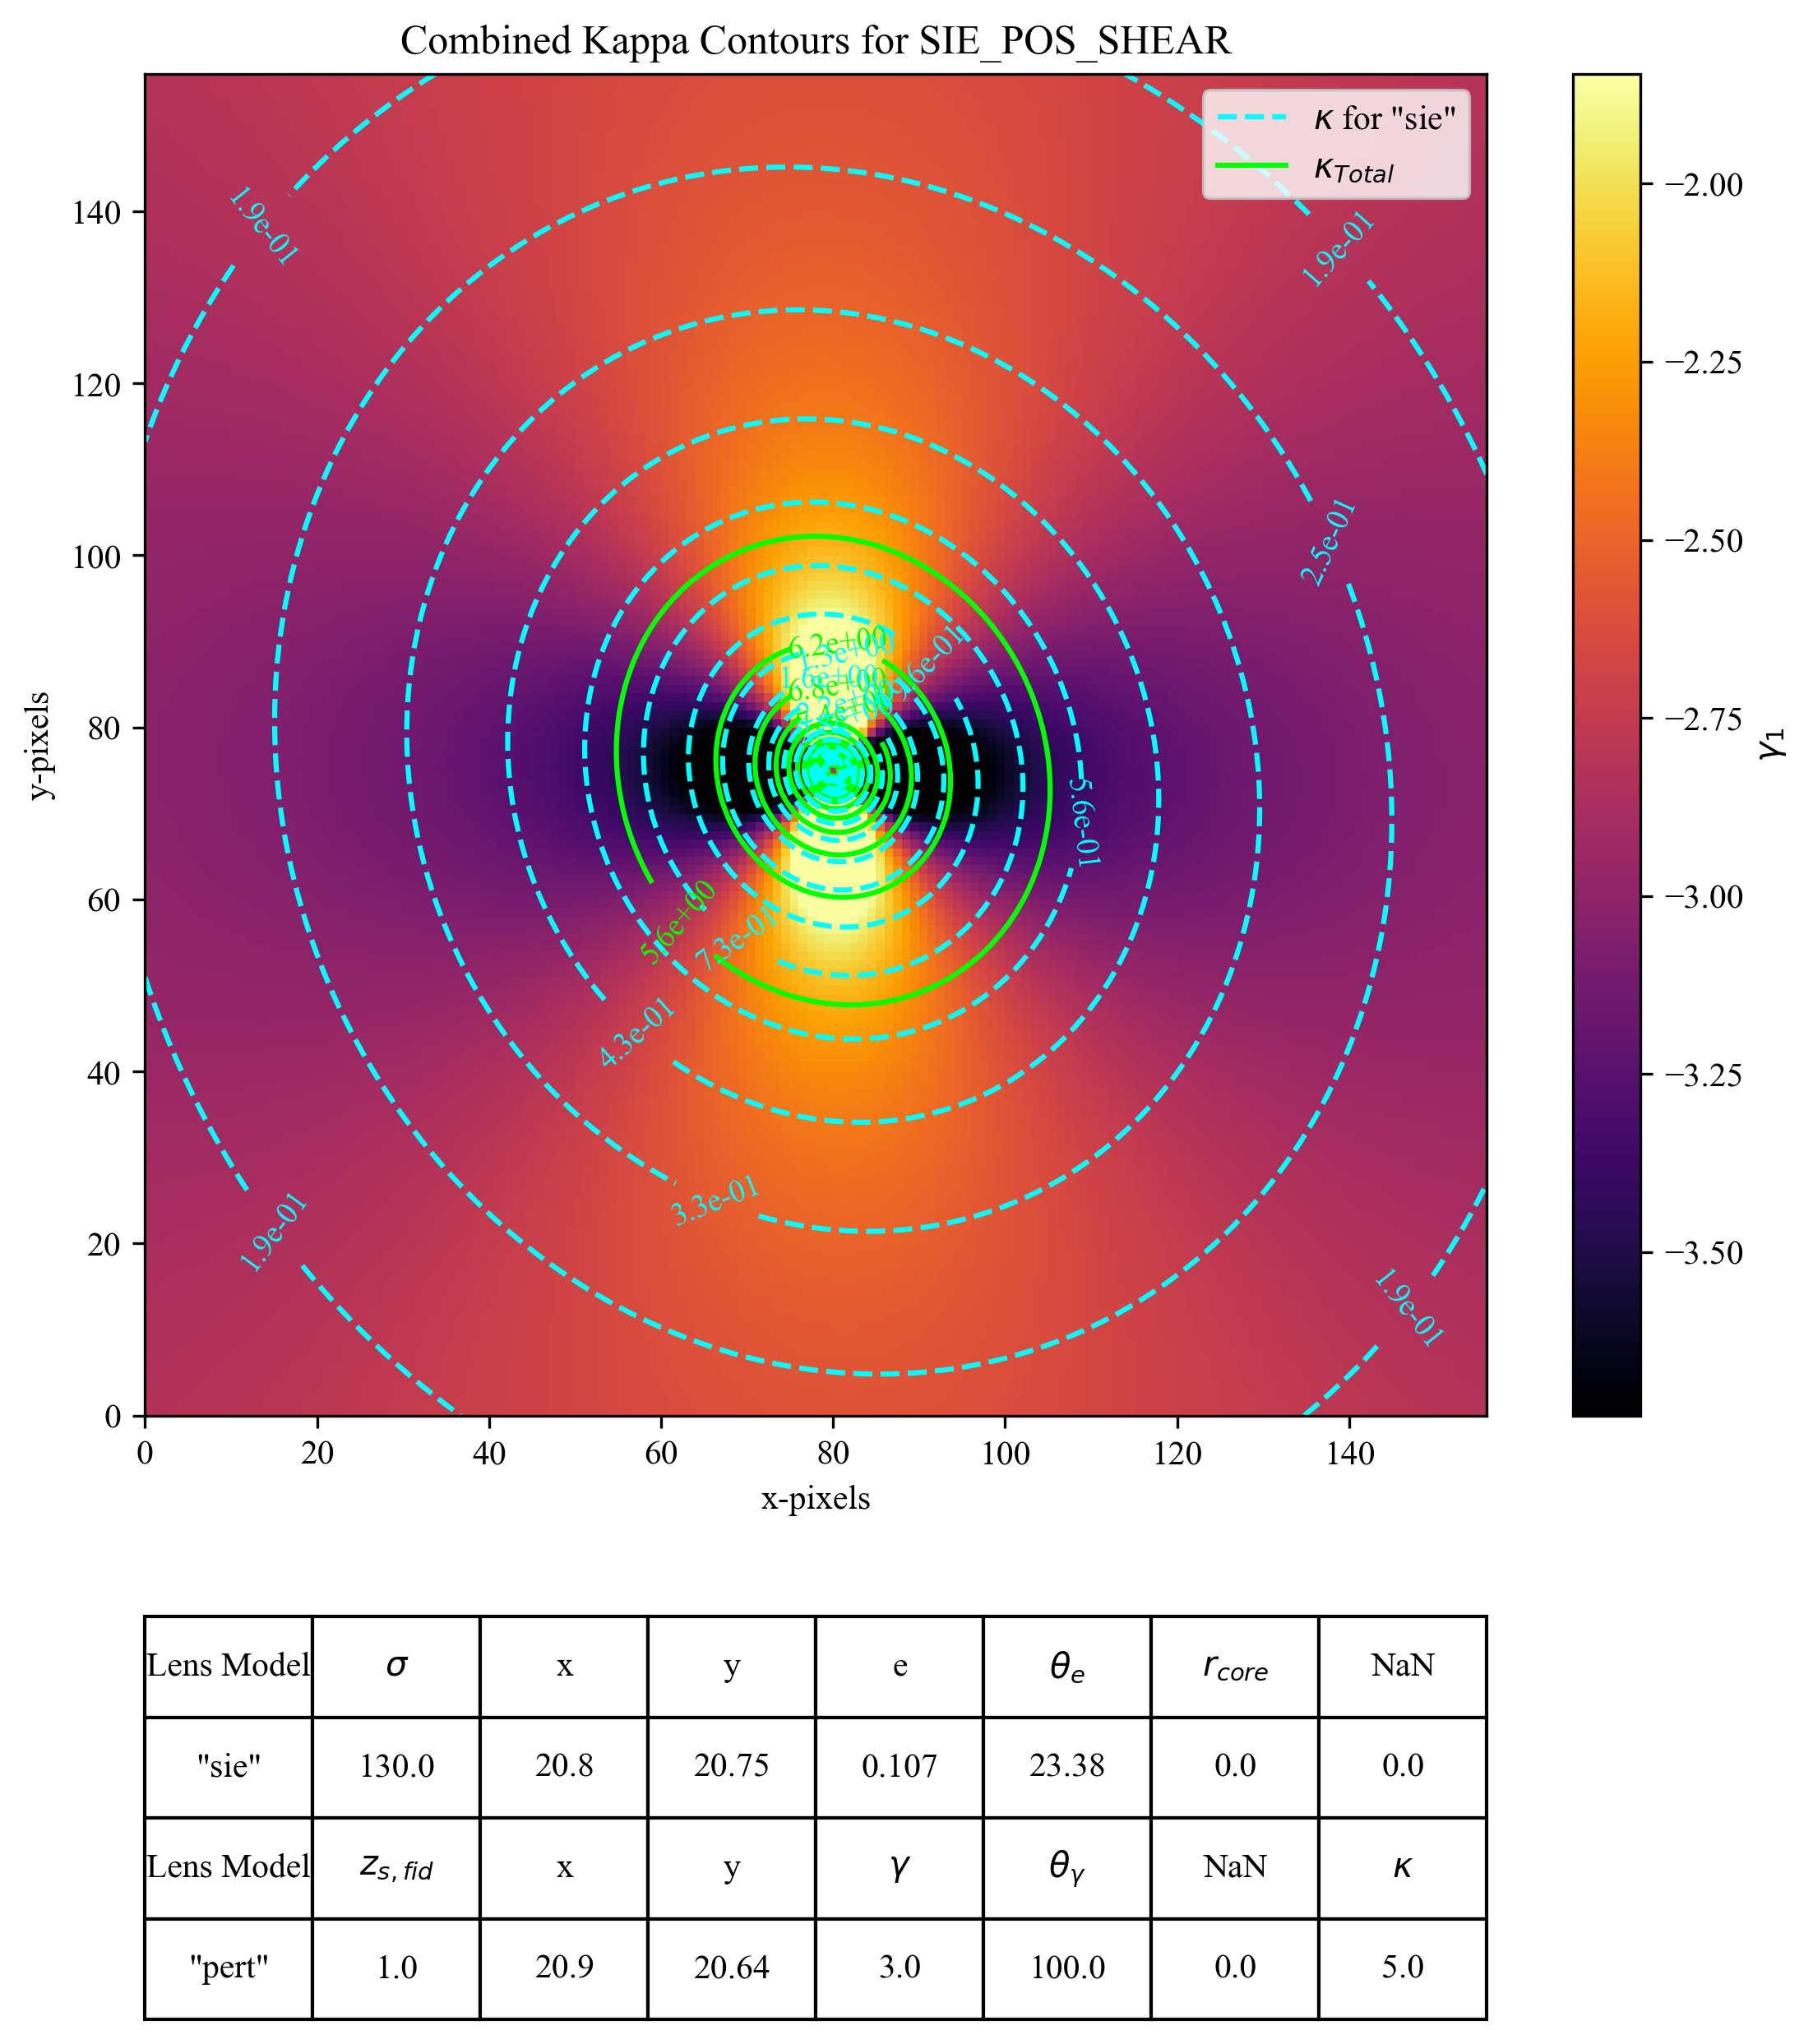

In [561]:
from IPython.display import display
from matplotlib.colors import LogNorm

# --- 1. Set up the Figure and Axes ---
plt.figure(figsize=(10, 8))
# Option 1: Use LogNorm for logarithmic contrast
# plt.imshow(gamma1, cmap='coolwarm', norm=LogNorm(vmin=gamma1.min()+1e-6, vmax=gamma1.max()))

# Option 2: Use percentiles for vmin/vmax to clip outliers and enhance contrast
vmin, vmax = np.percentile(gamma1, [1, 99])
# norm=ImageNormalize(gamma1, stretch=LinearStretch(), vmin=gamma1.min()+1e-1, vmax=gamma1.max())
plt.imshow(gamma1, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax, extent=[0, gamma1.shape[1], 0, gamma1.shape[0]])
plt.colorbar(label=r'$\gamma_1$')
ax = plt.gca()
ax.invert_yaxis()


# --- 2. Plot the first set of contours for kappa_macro ---
levels_macro = np.logspace(
    np.log10(kappa_macro.min() + 1e-6),
    np.log10(kappa_macro.max()),
    20
)
contour_macro = ax.contour(
    kappa_macro,
    levels=levels_macro,
    colors='lime',
    linewidths=1.5,
    linestyles='solid',
    extent=[0, kappa_macro.shape[1], 0, kappa_macro.shape[0]],
)
# --- ADD LABELS for the 'kappa_macro' contours ---
ax.clabel(
    contour_macro,
    levels=levels_macro[::1],  # Label every 3rd contour line to avoid clutter
    inline=True,               # Place labels inside the contour line
    fontsize=9,
    fmt='%1.1e',               # Format labels in scientific notation
    colors='lime',               # Match label color to the line color
)


# --- 3. Plot the second set of contours for kappa ---
levels_total = np.logspace(
    np.log10(kappa.min() + 1e-6),
    np.log10(kappa.max()),
    20
)
contour_total = ax.contour(
    kappa,
    levels=levels_total,
    colors='cyan',
    linewidths=1.5,
    linestyles='dashed',
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)
# --- ADD LABELS for the 'kappa' contours ---
ax.clabel(
    contour_total,
    levels=levels_total[::1],  # Label every 3rd contour line
    inline=True,
    fontsize=9,
    fmt='%1.1e',
    colors='cyan'
)


# --- 4. Finalize the Plot ---
legend_elements = [
    Line2D([0], [0], color='cyan', lw=1.5, linestyle='dashed', label=r'$\kappa$ for ' + df['Lens Name'][i]),
    Line2D([0], [0], color='lime', lw=1.5, linestyle='solid', label=r'$\kappa_{Total}$')
]

ax.set_title('Combined Kappa Contours for ' + model_ver)
ax.legend(handles=legend_elements)
ax.set_xlim(0, kappa.shape[1])
ax.set_ylim(0, kappa.shape[0])
ax.set_xlabel("x-pixels")
ax.set_ylabel("y-pixels")


# Convert DataFrame to string values for display
cell_text = final_df.values.astype(str)
col_labels = final_df.columns

# Add the table below the plot
the_table = ax.table(
    cellText=cell_text,
    loc='bottom',
    cellLoc='center',
    bbox=[0.0, -0.45, 1, 0.3]  # [left, bottom, width, height]
)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
plt.subplots_adjust(left=0.2, bottom=0.2)

# plt.savefig('kappa/Images/kappa_contours_combined_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()